<hr>
<h1>Predicting Benign and Malignant Classes in Mammograms Using Thresholded Data</h1>

<p>Jay Narhan</p>
June 2017

This is an application of the best performing models but using thresholded data instead of differenced data. See JN_DC_Diff_Diagnosis.ipynb for more background and details on the problem.

<hr>

In [1]:
import os
import sys
import time
import numpy as np

from tqdm import tqdm

import sklearn.metrics as skm
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

from skimage import color

import keras.callbacks as cb
import keras.utils.np_utils as np_utils
from keras import applications
from keras import regularizers
from keras.models import Sequential
from keras.constraints import maxnorm
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Dense, Dropout, Flatten, GaussianNoise

from matplotlib import pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (10,10)
np.set_printoptions(precision=2)

sys.path.insert(0, '../helper_modules/')
import jn_bc_helper as bc

Using Theano backend.


<h2>Reproducible Research</h2>

In [2]:
%%python
import os
os.system('python -V')
os.system('python ../helper_modules/Package_Versions.py')

scipy:           0.19.0
numpy:           1.12.1
matplotlib:      2.0.0
sklearn:         0.18.1
skimage:         0.13.0
theano:          0.9.0.dev-c697eeab84e5b8a74908da654b66ec9eca4f1291
tensorflow:      0.10.0
keras:           2.0.3


Python 2.7.13 :: Continuum Analytics, Inc.
Using Theano backend.


In [3]:
SEED = 7
np.random.seed(SEED)

CURR_DIR  = os.getcwd()
DATA_DIR  = '/Users/jnarhan/Dropbox/Breast_Cancer_Data/Data_Thresholded/ALL_IMGS/'
AUG_DIR   = '/Users/jnarhan/Dropbox/Breast_Cancer_Data/Data_Thresholded/AUG_DIAGNOSIS_IMGS/'
meta_file = '../../Meta_Data_Files/meta_data_all.csv'
PATHO_INX = 6    # Column number of pathology label in meta_file
FILE_INX  = 1    # Column number of File name in meta_file

meta_data, _ = tqdm( bc.load_meta(meta_file, patho_idx=PATHO_INX, file_idx=FILE_INX,
                                  balanceByRemoval=False, verbose=False) )

# Minor addition to reserve records in meta data for which we actually have images:
meta_data = bc.clean_meta(meta_data, DATA_DIR)

# Only work with benign and malignant classes:
for k,v in meta_data.items():
    if v not in ['benign', 'malignant']:
        del meta_data[k]

bc.pprint('Loading data')
cats = bc.bcLabels(['benign', 'malignant'])

# For smaller images supply tuple argument for a parameter 'imgResize':
# X_data, Y_data = bc.load_data(meta_data, DATA_DIR, cats, imgResize=(150,150)) 
X_data, Y_data = tqdm( bc.load_data(meta_data, DATA_DIR, cats) )

cls_cnts = bc.get_clsCnts(Y_data, cats)
bc.pprint('Before Balancing')
for k in cls_cnts:
    print '{0:10}: {1}'.format(k, cls_cnts[k])

100%|██████████| 2/2 [00:00<00:00, 13421.77it/s]


Number of entries in incoming meta_data: 5822
Images found: 5251
Images missing: 571
Number of entries of outgoing meta_data: 5251
------------
Loading data
------------


100%|██████████| 2/2 [00:00<00:00, 14169.95it/s]

----------------
Before Balancing
----------------
malignant : 948
benign    : 732


**Class Balancing**

Here - I look at a modified version of SMOTE, growing the under-represented class via synthetic augmentation, until there is a balance among the categories:

In [4]:
datagen = ImageDataGenerator(rotation_range=5, width_shift_range=.01, height_shift_range=0.01,
                             data_format='channels_first')

In [5]:
X_data, Y_data = bc.balanceViaSmote(cls_cnts, meta_data, DATA_DIR, AUG_DIR, cats, 
                                    datagen, X_data, Y_data, seed=SEED, verbose=True)

---------------
After Balancing
---------------
malignant : 948
benign    : 948


**Create the Training and Test Datasets**

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data,
                                                    test_size=0.20, # deviation given small data set
                                                    random_state=SEED,
                                                    stratify=zip(*Y_data)[0])

print 'Size of X_train: {:>5}'.format(len(X_train))
print 'Size of X_test: {:>5}'.format(len(X_test))
print 'Size of Y_train: {:>5}'.format(len(Y_train))
print 'Size of Y_test: {:>5}'.format(len(Y_test))

print X_train.shape
print X_test.shape
print Y_train.shape
print Y_test.shape

data = [X_train, X_test, Y_train, Y_test]

Size of X_train:  1516
Size of X_test:   380
Size of Y_train:  1516
Size of Y_test:   380
(1516, 255, 255)
(380, 255, 255)
(1516, 1)
(380, 1)


<h2>Support Vector Machine Model</h2>

In [7]:
X_train_svm = X_train.reshape( (X_train.shape[0], -1)) 
X_test_svm  = X_test.reshape( (X_test.shape[0], -1))

In [8]:
SVM_model = SVC(gamma=0.001)
SVM_model.fit( X_train_svm, Y_train)

/Users/jnarhan/miniconda2/envs/bc_venv/lib/python2.7/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [9]:
predictOutput = SVM_model.predict(X_test_svm)
svm_acc = metrics.accuracy_score(y_true=Y_test, y_pred=predictOutput)

print 'SVM Accuracy: {: >7.2f}%'.format(svm_acc * 100)
print 'SVM Error: {: >10.2f}%'.format(100 - svm_acc * 100)

SVM Accuracy:   66.32%
SVM Error:      33.68%


Normalized confusion matrix
[[ 0.68  0.32]
 [ 0.36  0.64]]


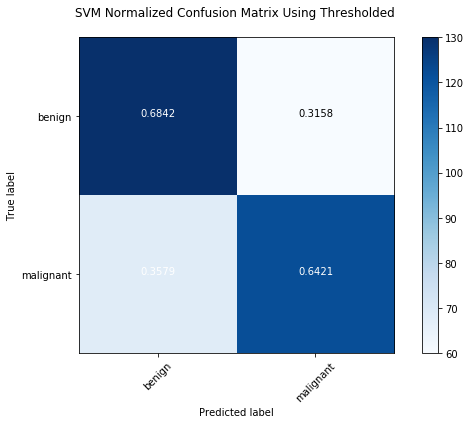

In [10]:
svm_matrix = skm.confusion_matrix(y_true=Y_test, y_pred=predictOutput)
numBC = bc.reverseDict(cats)
class_names = numBC.values()

plt.figure(figsize=(8,6))
bc.plot_confusion_matrix(svm_matrix, classes=class_names, normalize=True, 
                         title='SVM Normalized Confusion Matrix Using Thresholded \n')
plt.tight_layout()
plt.savefig('../../figures/jn_SVM_Diagnosis_CM_Threshold_20170609.png', dpi=100)

Confusion matrix, without normalization
[[130  60]
 [ 68 122]]


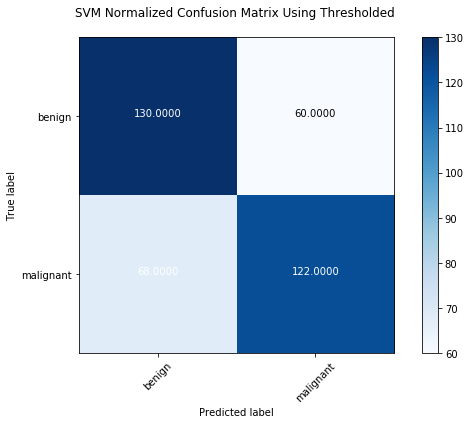

In [11]:
plt.figure(figsize=(8,6))
bc.plot_confusion_matrix(svm_matrix, classes=class_names, normalize=False, 
                         title='SVM Normalized Confusion Matrix Using Thresholded \n')
plt.tight_layout()

In [12]:
bc.cat_stats(svm_matrix)

{'Accuracy': 66.32,
 'F1': 0.66,
 'NPV': 65.66,
 'PPV': 67.03,
 'Sensitivity': 64.21,
 'Specificity': 68.42}

<h2>CNN Modelling Using VGG16 in Transfer Learning</h2>

In [13]:
def VGG_Prep(img_data):
    """
    :param img_data: training or test images of shape [#images, height, width]
    :return: the array transformed to the correct shape for the VGG network
                shape = [#images, height, width, 3] transforms to rgb and reshapes
    """
    images = np.zeros([len(img_data), img_data.shape[1], img_data.shape[2], 3])
    for i in range(0, len(img_data)):
        im = (img_data[i] * 255)        # Original imagenet images were not rescaled
        im = color.gray2rgb(im)
        images[i] = im
    return(images)

In [14]:
def vgg16_bottleneck(data, modelPath, fn_train_feats, fn_train_lbls, fn_test_feats, fn_test_lbls):
    # Loading data
    X_train, X_test, Y_train, Y_test = data
    
    print('Preparing the Training Data for the VGG_16 Model.')
    X_train = VGG_Prep(X_train)
    print('Preparing the Test Data for the VGG_16 Model')
    X_test = VGG_Prep(X_test)
        
    print('Loading the VGG_16 Model')
    # "model" excludes top layer of VGG16:
    model = applications.VGG16(include_top=False, weights='imagenet') 
        
    # Generating the bottleneck features for the training data
    print('Evaluating the VGG_16 Model on the Training Data')
    bottleneck_features_train = model.predict(X_train)
    
    # Saving the bottleneck features for the training data
    featuresTrain = os.path.join(modelPath, fn_train_feats)
    labelsTrain = os.path.join(modelPath, fn_train_lbls)
    print('Saving the Training Data Bottleneck Features.')
    np.save(open(featuresTrain, 'wb'), bottleneck_features_train)
    np.save(open(labelsTrain, 'wb'), Y_train)

    # Generating the bottleneck features for the test data
    print('Evaluating the VGG_16 Model on the Test Data')
    bottleneck_features_test = model.predict(X_test)
    
    # Saving the bottleneck features for the test data
    featuresTest = os.path.join(modelPath, fn_test_feats)
    labelsTest = os.path.join(modelPath, fn_test_lbls)
    print('Saving the Test Data Bottleneck Feaures.')
    np.save(open(featuresTest, 'wb'), bottleneck_features_test)
    np.save(open(labelsTest, 'wb'), Y_test)

In [15]:
# Locations for the bottleneck and labels files that we need
train_bottleneck = '2Class_Lesions_VGG16_bottleneck_features_train_threshold.npy'
train_labels     = '2Class_Lesions_VGG16_labels_train_threshold.npy'
test_bottleneck  = '2Class_Lesions_VGG16_bottleneck_features_test_threshold.npy'
test_labels      = '2Class_Lesions_VGG16_labels_test_threshold.npy'
modelPath = os.getcwd()

top_model_weights_path = './weights/'

np.random.seed(SEED)
vgg16_bottleneck(data, modelPath, train_bottleneck, train_labels, test_bottleneck, test_labels)

Preparing the Training Data for the VGG_16 Model.
Preparing the Test Data for the VGG_16 Model
Loading the VGG_16 Model
Evaluating the VGG_16 Model on the Training Data
Saving the Training Data Bottleneck Features.
Evaluating the VGG_16 Model on the Test Data
Saving the Test Data Bottleneck Feaures.


In [16]:
def train_top_model(train_feats, train_lab, test_feats, test_lab, model_path, model_save, epoch = 50, batch = 64):
    start_time = time.time()
    
    train_bottleneck = os.path.join(model_path, train_feats)
    train_labels = os.path.join(model_path, train_lab)
    test_bottleneck = os.path.join(model_path, test_feats)
    test_labels = os.path.join(model_path, test_lab)
    
    history = bc.LossHistory()
    
    X_train = np.load(train_bottleneck)
    Y_train = np.load(train_labels)
    Y_train = np_utils.to_categorical(Y_train, num_classes=2)
    
    X_test = np.load(test_bottleneck)
    Y_test = np.load(test_labels)
    Y_test = np_utils.to_categorical(Y_test, num_classes=2)

    model = Sequential()
    model.add(Flatten(input_shape=X_train.shape[1:]))
    model.add( Dropout(0.7))
    
    model.add( Dense(256, activation='relu', kernel_constraint= maxnorm(3.)) )
    model.add( Dropout(0.5))
    
    # Softmax for probabilities for each class at the output layer
    model.add( Dense(2, activation='softmax'))
    
    model.compile(optimizer='rmsprop',  # adadelta
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

    model.fit(X_train, Y_train,
              epochs=epoch,
              batch_size=batch,
              callbacks=[history],
              validation_data=(X_test, Y_test),
              verbose=2)
    
    print "Training duration : {0}".format(time.time() - start_time)
    score = model.evaluate(X_test, Y_test, batch_size=16, verbose=2)

    print "Network's test score [loss, accuracy]: {0}".format(score)
    print 'CNN Error: {:.2f}%'.format(100 - score[1] * 100)
    
    bc.save_model(model_save, model, "jn_VGG16_Diagnosis_top_weights_threshold.h5")
    
    return model, history.losses, history.acc, score

Train on 1516 samples, validate on 380 samples
Epoch 1/100
4s - loss: 6.5469 - acc: 0.5660 - val_loss: 5.6614 - val_acc: 0.6342
Epoch 2/100
4s - loss: 6.0066 - acc: 0.6022 - val_loss: 5.6908 - val_acc: 0.6158
Epoch 3/100
4s - loss: 5.6912 - acc: 0.6266 - val_loss: 5.6555 - val_acc: 0.6289
Epoch 4/100
4s - loss: 5.6275 - acc: 0.6392 - val_loss: 6.4929 - val_acc: 0.5816
Epoch 5/100
4s - loss: 5.7286 - acc: 0.6313 - val_loss: 6.1990 - val_acc: 0.5974
Epoch 6/100
4s - loss: 5.3939 - acc: 0.6524 - val_loss: 5.4737 - val_acc: 0.6421
Epoch 7/100
4s - loss: 5.1540 - acc: 0.6669 - val_loss: 5.3344 - val_acc: 0.6579
Epoch 8/100
4s - loss: 4.7835 - acc: 0.6893 - val_loss: 5.5056 - val_acc: 0.6474
Epoch 9/100
4s - loss: 5.2417 - acc: 0.6623 - val_loss: 4.9187 - val_acc: 0.6816
Epoch 10/100
4s - loss: 4.9289 - acc: 0.6801 - val_loss: 5.5650 - val_acc: 0.6474
Epoch 11/100
4s - loss: 5.3987 - acc: 0.6544 - val_loss: 5.9577 - val_acc: 0.6237
Epoch 12/100
4s - loss: 5.2896 - acc: 0.6609 - val_loss: 5.3

Network's test score [loss, accuracy]: [5.0522738255952531, 0.68157894705471245]
CNN Error: 31.84%
Model and Weights Saved to Disk


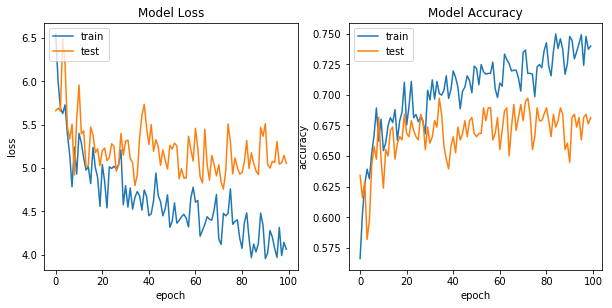

In [17]:
np.random.seed(SEED)
(trans_model, loss_cnn, acc_cnn, test_score_cnn) = train_top_model(train_feats=train_bottleneck,
                                                                   train_lab=train_labels, 
                                                                   test_feats=test_bottleneck, 
                                                                   test_lab=test_labels,
                                                                   model_path=modelPath, 
                                                                   model_save=top_model_weights_path,
                                                                   epoch=100)
plt.figure(figsize=(10,10))
bc.plot_losses(loss_cnn, acc_cnn)
plt.savefig('../../figures/epoch_figures/jn_Transfer_Diagnosis_Threshold_20170609.png', dpi=100)

Transfer Learning CNN Accuracy:   68.16%
Transfer Learning CNN Error:      31.84%
Normalized confusion matrix
[[ 0.77  0.23]
 [ 0.41  0.59]]


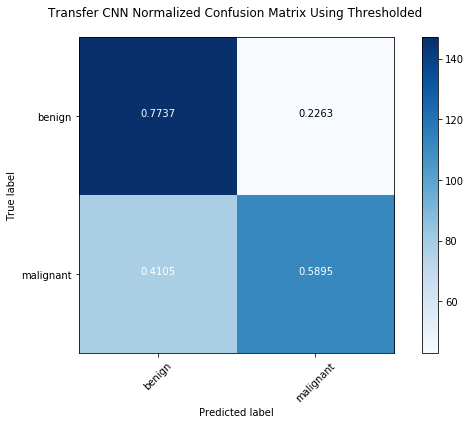

In [18]:
print 'Transfer Learning CNN Accuracy: {: >7.2f}%'.format(test_score_cnn[1] * 100)
print 'Transfer Learning CNN Error: {: >10.2f}%'.format(100 - test_score_cnn[1] * 100)

predictOutput = bc.predict(trans_model, np.load(test_bottleneck))
trans_matrix = skm.confusion_matrix(y_true=Y_test, y_pred=predictOutput)

plt.figure(figsize=(8,6))
bc.plot_confusion_matrix(trans_matrix, classes=class_names, normalize=True,
                         title='Transfer CNN Normalized Confusion Matrix Using Thresholded \n')
plt.tight_layout()
plt.savefig('../../figures/TMP_jn_Transfer_Diagnosis_CM_Threshold_20170609.png', dpi=100)

Confusion matrix, without normalization
[[147  43]
 [ 78 112]]


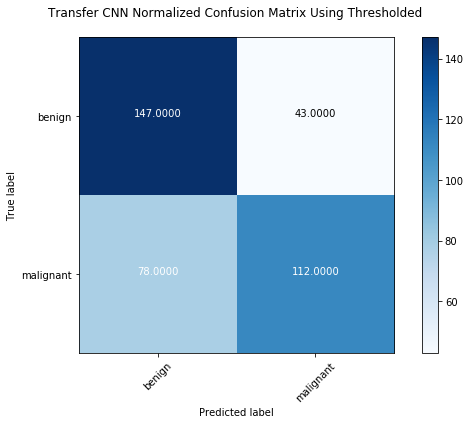

In [19]:
plt.figure(figsize=(8,6))
bc.plot_confusion_matrix(trans_matrix, classes=class_names, normalize=False,
                         title='Transfer CNN Normalized Confusion Matrix Using Thresholded \n')
plt.tight_layout()

In [20]:
bc.cat_stats(trans_matrix)

{'Accuracy': 68.16,
 'F1': 0.65,
 'NPV': 65.33,
 'PPV': 72.26,
 'Sensitivity': 58.95,
 'Specificity': 77.37}

<h2>Core CNN Modelling</h2>

**Prep and package the data for Keras processing:**

In [21]:
data = [X_train, X_test, Y_train, Y_test]
X_train, X_test, Y_train, Y_test = bc.prep_data(data, cats)
data = [X_train, X_test, Y_train, Y_test]

print X_train.shape
print X_test.shape
print Y_train.shape
print Y_test.shape

Prep data for NNs ...
Data Prepped for Neural Nets.
(1516, 1, 255, 255)
(380, 1, 255, 255)
(1516, 2)
(380, 2)


**Heavy Regularization**

In [28]:
def diff_model_v7_reg(numClasses, input_shape=(3, 150,150), add_noise=False, noise=0.01, verbose=False):
    model = Sequential()
    if (add_noise):
        model.add( GaussianNoise(noise, input_shape=input_shape))
        model.add( Convolution2D(filters=16, 
                                 kernel_size=(5,5), 
                                 data_format='channels_first',
                                 padding='same',
                                 activation='relu'))
    else:
        model.add( Convolution2D(filters=16, 
                                 kernel_size=(5,5), 
                                 data_format='channels_first',
                                 padding='same',
                                 activation='relu',
                                 input_shape=input_shape))
    # model.add( Dropout(0.7))
    model.add( Dropout(0.5))
    
    model.add( Convolution2D(filters=32, kernel_size=(3,3), 
                             data_format='channels_first', padding='same', activation='relu'))
    model.add( MaxPooling2D(pool_size= (2,2), data_format='channels_first'))
    # model.add( Dropout(0.4))
    model.add( Dropout(0.25))
    model.add( Convolution2D(filters=32, kernel_size=(3,3), 
                             data_format='channels_first', activation='relu'))
    
    model.add( Convolution2D(filters=64, kernel_size=(3,3), 
                             data_format='channels_first', padding='same', activation='relu',
                             kernel_regularizer=regularizers.l2(0.01)))
    model.add( MaxPooling2D(pool_size= (2,2), data_format='channels_first'))
    model.add( Convolution2D(filters=64, kernel_size=(3,3), 
                             data_format='channels_first', activation='relu',
                             kernel_regularizer=regularizers.l2(0.01)))
    #model.add( Dropout(0.4))
    model.add( Dropout(0.25))
    
    model.add( Convolution2D(filters=128, kernel_size=(3,3), 
                             data_format='channels_first', padding='same', activation='relu',
                             kernel_regularizer=regularizers.l2(0.01)))
    model.add( MaxPooling2D(pool_size= (2,2), data_format='channels_first'))
    
    model.add( Convolution2D(filters=128, kernel_size=(3,3), 
                             data_format='channels_first', activation='relu',
                             kernel_regularizer=regularizers.l2(0.01)))
    #model.add(Dropout(0.4))
    model.add( Dropout(0.25))
    
    model.add( Flatten())
    
    model.add( Dense(128, activation='relu', kernel_constraint= maxnorm(3.)) )
    # model.add( Dropout(0.4))
    model.add( Dropout(0.25))
    
    model.add( Dense(64, activation='relu', kernel_constraint= maxnorm(3.)) )
    # model.add( Dropout(0.4))
    model.add( Dropout(0.25))
    
    # Softmax for probabilities for each class at the output layer
    model.add( Dense(numClasses, activation='softmax'))
    
    if verbose:
        print( model.summary() )
    
    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    return model

In [29]:
diff_model7_noise_reg = diff_model_v7_reg(len(cats),
                                          input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]),
                                          add_noise=True, verbose=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise_2 (GaussianNo (None, 1, 255, 255)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 255, 255)      416       
_________________________________________________________________
dropout_9 (Dropout)          (None, 16, 255, 255)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 255, 255)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 127, 127)      0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 32, 127, 127)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 125, 125)      9248      
__________

Training model...
Train on 1516 samples, validate on 380 samples
Epoch 1/50
462s - loss: 2.5185 - acc: 0.5165 - val_loss: 1.6954 - val_acc: 0.5000
Epoch 2/50
440s - loss: 1.3317 - acc: 0.5343 - val_loss: 1.0157 - val_acc: 0.5737
Epoch 3/50
429s - loss: 0.8887 - acc: 0.5594 - val_loss: 0.7735 - val_acc: 0.5737
Epoch 4/50
431s - loss: 0.7237 - acc: 0.6214 - val_loss: 0.7004 - val_acc: 0.6211
Epoch 5/50
433s - loss: 0.6887 - acc: 0.6135 - val_loss: 0.6824 - val_acc: 0.5921
Epoch 6/50
433s - loss: 0.6751 - acc: 0.5996 - val_loss: 0.6897 - val_acc: 0.6053
Epoch 7/50
447s - loss: 0.6721 - acc: 0.6141 - val_loss: 0.6731 - val_acc: 0.6158
Epoch 8/50
433s - loss: 0.6587 - acc: 0.6141 - val_loss: 0.6705 - val_acc: 0.6158
Epoch 9/50
433s - loss: 0.6546 - acc: 0.6293 - val_loss: 0.6658 - val_acc: 0.6184
Epoch 10/50
431s - loss: 0.6442 - acc: 0.6234 - val_loss: 0.6630 - val_acc: 0.6079
Epoch 11/50
430s - loss: 0.6440 - acc: 0.6398 - val_loss: 0.6743 - val_acc: 0.5947
Epoch 12/50
430s - loss: 0.6453

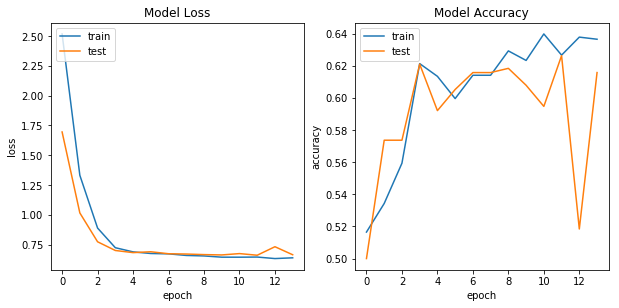

In [30]:
np.random.seed(SEED)

(cnn_model, loss_cnn, acc_cnn, test_score_cnn) = bc.run_network(model=diff_model7_noise_reg, earlyStop=True,
                                                                data=data, 
                                                                epochs=50, batch=64)
plt.figure(figsize=(10,10))
bc.plot_losses(loss_cnn, acc_cnn)
plt.savefig('../../figures/epoch_figures/jn_Core_CNN_Diagnosis_Threshold_20170609.png', dpi=100)

In [31]:
bc.save_model(dir_path='./weights/', model=cnn_model, name='jn_Core_CNN_Diagnosis_Threshold_20170609')

Model and Weights Saved to Disk


Core CNN Accuracy:   61.58%
Core CNN Error:      38.42%
Normalized confusion matrix
[[ 0.67  0.33]
 [ 0.44  0.56]]


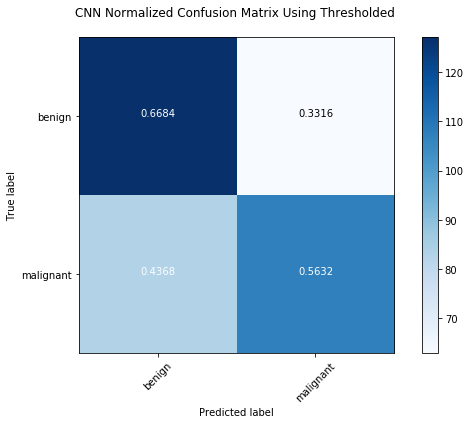

In [32]:
print 'Core CNN Accuracy: {: >7.2f}%'.format(test_score_cnn[1] * 100)
print 'Core CNN Error: {: >10.2f}%'.format(100 - test_score_cnn[1] * 100)

predictOutput = bc.predict(cnn_model, X_test)

cnn_matrix = skm.confusion_matrix(y_true=[val.argmax() for val in Y_test], y_pred=predictOutput)

plt.figure(figsize=(8,6))
bc.plot_confusion_matrix(cnn_matrix, classes=class_names, normalize=True,
                         title='CNN Normalized Confusion Matrix Using Thresholded \n')
plt.tight_layout()
plt.savefig('../../figures/jn_Core_CNN_Diagnosis_Threshold_201706090.png', dpi=100)

Confusion matrix, without normalization
[[127  63]
 [ 83 107]]


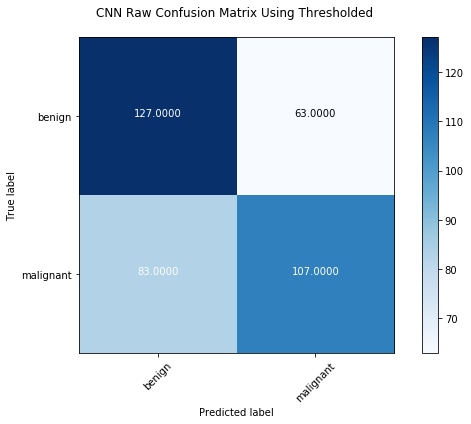

In [33]:
plt.figure(figsize=(8,6))
bc.plot_confusion_matrix(cnn_matrix, classes=class_names, normalize=False,
                         title='CNN Raw Confusion Matrix Using Thresholded \n')
plt.tight_layout()

In [34]:
bc.cat_stats(cnn_matrix)

{'Accuracy': 61.58,
 'F1': 0.59,
 'NPV': 60.48,
 'PPV': 62.94,
 'Sensitivity': 56.32,
 'Specificity': 66.84}